# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Agent Service

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Pre-created Agent IDs (must be created via common/create_azure_ai_agents.py)
PlannerAgentID=your_planner_agent_id
BingSearchAgentID=your_bing_search_agent_id
SummaryAgentID=your_summary_agent_id
ResearchAgentID=your_research_agent_id
PeerReviewAgentID=your_peer_review_agent_id
```

**Note:** This notebook uses **pure Azure AI Agents** - all agents must be pre-created in Azure AI Foundry. Unlike notebooks 01 and 02, no agents are created inline. Run the agent creation cells below (commented out) once to create your agents, then use their IDs in subsequent runs.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
import os

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating Azure AI Agents (One-time Setup)

The following cell will **create all Azure AI Agents** required for this workflow. You only need to run this cell **once** to create the agents, then save their IDs to your `.env` file.

After creating the agents, uncomment the fetch agents cell below and comment out this creation cell for subsequent runs.

In [3]:
# from common.create_azure_ai_agents import (
#     create_bing_search_agent,
#     create_research_plan_agent,
#     create_summary_agent,
#     create_research_report_agent,
#     create_peer_review_agent
# )

# planner_agent = create_research_plan_agent(project_client=project_client)
# bing_search_agent = create_bing_search_agent(project_client=project_client)
# summary_agent = create_summary_agent(project_client=project_client)
# research_agent = create_research_report_agent(project_client=project_client)
# peer_review_agent = create_peer_review_agent(project_client=project_client)

### Fetch Agents from Azure AI Foundry

Once you've created your agents (using the cell above), use this cell to retrieve them by their IDs from your `.env` file. This is the standard approach for working with pre-created Azure AI Agents.

In [4]:
planner_agent = project_client.agents.get_agent(agent_id=os.getenv("PlannerAgentID"))
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("BingSearchAgentID"))
summary_agent = project_client.agents.get_agent(agent_id=os.getenv("SummaryAgentID"))
research_agent = project_client.agents.get_agent(agent_id=os.getenv("ResearchAgentID"))
peer_review_agent = project_client.agents.get_agent(agent_id=os.getenv("PeerReviewAgentID"))

### Update Agent Instructions

This cell updates the system instructions for all agents with current date awareness and any refined prompts. Run this cell each time you want to ensure agents have the latest instructions, especially for date-sensitive queries.

In [5]:
from common.update_instructions import (
    update_planner_instructions,
    update_bing_instructions,
    update_summary_instructions,
    update_research_instructions,
    update_peer_review_instructions
)

planner_agent = update_planner_instructions(agent=planner_agent)
bing_search_agent = update_bing_instructions(agent=bing_search_agent)
summary_agent = update_summary_instructions(agent=summary_agent)
research_agent = update_research_instructions(agent=research_agent)
peer_review_agent = update_peer_review_instructions(agent=peer_review_agent)

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

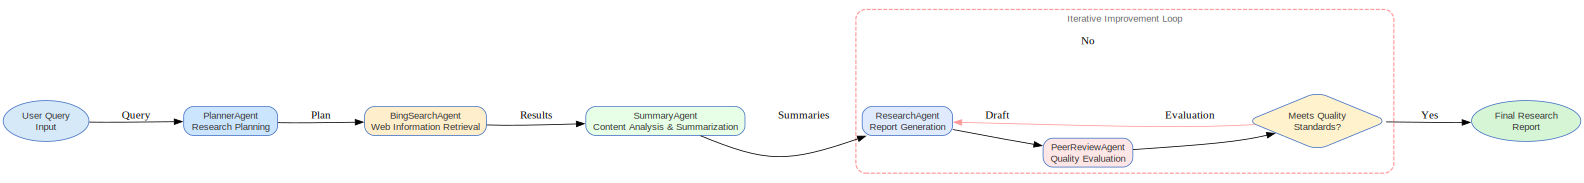

In [6]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [7]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [8]:
from azure.ai.agents.models import MessageRole
from common.data_models import ResearchPlan
from common.utils_ai_agents import (
    add_user_message_to_thread,
    invoke_agent
)
import json

# create a thread and add the user message
thread = project_client.agents.threads.create()
add_user_message_to_thread(project_client, thread.id, user_query)

# invoke the planner agent to create a research plan
planner_agent_output, thread = invoke_agent(
    project_client=project_client,
    thread=thread,
    agent=planner_agent
)

# parse the output to a ResearchPlan object
plan_data = json.loads(planner_agent_output)
plan = ResearchPlan(**plan_data)

# delete the thread
project_client.agents.threads.delete(thread_id=thread.id)

In [9]:
plan.research_tasks[0].search_queries

['Classical machine learning vs deep learning vs generative AI methodologies',
 'Technical comparison of classical ML, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

MAX_WORKERS = 8  # adjust for your rate limits

def run_one_query(subtopic_name: str, query: str) -> Dict[str, Any]:
    prompt = f"""
    Research the following query: {query}
    This is related to subtopic: {subtopic_name}
    Please provide the information and cite your sources using the available tools.
    """
    thread = None
    try:
        thread = project_client.agents.threads.create()
        add_user_message_to_thread(project_client, thread.id, prompt)

        _out, _ = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=bing_search_agent
        )

        text, urls = extract_agent_response_and_urls(project_client, thread.id, query)
        return {"query": query, "agent_response": text, "results": urls}
    except Exception as e:
        return {"query": query, "results": [], "error": str(e)}
    finally:
        try:
            if thread is not None:
                project_client.agents.threads.delete(thread_id=thread.id)
        except Exception:
            pass

# Flatten tasks
# si: index of the subtopic
# qi: index of the query within that subtopic
# st.subtopic: the subtopic name
# q: the query text

tasks: List[Tuple[int, int, str, str]] = [
    (si, qi, st.subtopic, q)
    for si, st in enumerate(plan.research_tasks)
    for qi, q in enumerate(st.search_queries)
]

# Run in parallel
results = defaultdict(dict)  # results[si][qi] = entry
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    fmap = {ex.submit(run_one_query, subtopic_name, query): (si, qi)
            for si, qi, subtopic_name, query in tasks}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Running research queries in parallel"):
        si, qi = fmap[fut]
        try:
            results[si][qi] = fut.result()
        except Exception as e:
            results[si][qi] = {"query": tasks[si][3], "results": [], "error": str(e)}

# Rebuild in original shape and order
search_results: List[Dict[str, Any]] = []
for si, st in enumerate(plan.research_tasks):
    queries = [results[si].get(qi, {"query": q, "results": [], "error": "Missing result"})
               for qi, q in enumerate(st.search_queries)]
    search_results.append({"subtopic": st.subtopic, "queries": queries})

# Quick status
for block in search_results:
    ok = sum(1 for q in block["queries"] if "error" not in q)
    print(f"{block['subtopic']}: {ok}/{len(block['queries'])} queries succeeded")


Running research queries in parallel: 100%|██████████| 6/6 [00:38<00:00,  6.50s/it]

Methodological and technical distinctions: 2/2 queries succeeded
Typical use cases and applications: 2/2 queries succeeded
Advantages and limitations of each approach: 2/2 queries succeeded


In [11]:
print(f"Planned total search queries: {sum(1 for task in plan.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 6

Actually total search queries: 6



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_summary import collect_responses_and_citations

MAX_WORKERS_SUMMARY = 5

def summarize_one(subtopic_result: Dict[str, Any]) -> Dict[str, Any]:
    all_responses, unique_citations = collect_responses_and_citations(subtopic_result)
    content = "\n\n---\n\n".join(all_responses)

    summary = "No content found to summarize for this subtopic."
    thread = None
    if content:
        summary_prompt = (
            f"Summarize the following information related to the subtopic "
            f"'{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content}"
        )
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, summary_prompt)
            out, _ = invoke_agent(project_client=project_client, thread=thread, agent=summary_agent)
            summary = out.strip()
        except Exception as e:
            sub = subtopic_result.get('subtopic', 'Unknown Subtopic')
            summary = f"Error during summarization for subtopic '{sub}'. Details: {e}"
        finally:
            try:
                if thread is not None:
                    project_client.agents.threads.delete(thread_id=thread.id)
            except Exception:
                pass

    citations_list = [{"title": t, "url": u} for (t, u) in unique_citations]
    return {
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"),
        "summary": summary,
        "citations": citations_list,
    }

# Run all subtopics in parallel and preserve order
mapped_chunks: List[Dict[str, Any]] = [None] * len(search_results)

with ThreadPoolExecutor(max_workers=MAX_WORKERS_SUMMARY) as ex:
    fmap = {ex.submit(summarize_one, subtopic_result): i
            for i, subtopic_result in enumerate(search_results)}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Summarizing subtopics in parallel"):
        i = fmap[fut]
        try:
            mapped_chunks[i] = fut.result()
        except Exception as e:
            sub = search_results[i].get("subtopic", "Unknown Subtopic")
            mapped_chunks[i] = {
                "subtopic": sub,
                "summary": f"Error during summarization for subtopic '{sub}'. Details: {e}",
                "citations": [],
            }

# Optional: quick status
ok = sum(1 for m in mapped_chunks if m and not m["summary"].startswith("Error during summarization"))
print(f"Summaries completed: {ok}/{len(mapped_chunks)}")


Summarizing subtopics in parallel: 100%|██████████| 3/3 [00:34<00:00, 11.50s/it]

Summaries completed: 3/3


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [13]:
def print_thread_messages(thread):
    messages = project_client.agents.messages.list(thread_id=thread.id)
    for m in messages:
        print(f"roll: {m.role}")
        print(f"agent_id: {m.agent_id}")
        print(f"content: {m.content[0]['text']['value']}")
        print("---")

In [14]:
from common.data_models import ComprehensiveResearchReport, PeerReviewFeedback
from common.utils_ai_agents import add_user_message_to_thread

def loop_agents(project_client, agent_a, agent_b, initial_input, max_iterations=10):
    """
    Loop between two agents until agent B produces the target output.
    
    Args:
        agent_a: Function that takes input and returns output
        agent_b: Function that takes input and returns output
        initial_input: Starting input for agent A
        max_iterations: Safety limit to prevent infinite loops
    
    Returns:
        The final output from agent B, or None if max iterations reached
    """
    current_input = initial_input
    thread = project_client.agents.threads.create()
    add_user_message_to_thread(project_client, thread.id, current_input)

    for i in range(max_iterations):
        # Agent A processes the input and produces output
        a_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_a
        )

        handover_message = f"A research agent has produced a research report. Please review it."
        add_user_message_to_thread(project_client, thread.id, handover_message)
        
        # Agent B reviews the output
        b_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_b
        )

        b_output_json = json.loads(b_output)
        review = PeerReviewFeedback(**b_output_json)

        # Check if B produced the target output
        if review.is_satisfactory is not False:
            print(f"Target output reached after {i+1} iterations!")
            report_json = json.loads(a_output)
            final_report = ComprehensiveResearchReport(**report_json)

            # delete the thread
            # print_thread_messages(thread)
            project_client.agents.threads.delete(thread_id=thread.id)
            return final_report
        
        # Use B's output as input for the next iteration
        current_input = b_output
        
        handover_message = f"Peer review agent has provided feedback. Please revise the research report based on the feedback."
        add_user_message_to_thread(project_client, thread.id, handover_message)

    # delete the thread
    # print_thread_messages(thread)
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"Max iterations ({max_iterations}) reached without finding target output")

    return None

In [15]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

research_query = (
    "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
    "using the following content. **Minimize bullet points** and ensure the final text resembles "
    "a cohesive, academic-style paper:\n\n"
    f"{research_input_prompt}\n\n"
    "As a final reminder, don't forget to include the citation list at the end of the report."
)

# Run the loop
final_report = loop_agents(
    project_client=project_client,
    agent_a=research_agent,
    agent_b=peer_review_agent,
    initial_input=research_query,
    max_iterations=10
)

Target output reached after 1 iterations!


In [16]:
from IPython.display import display, Markdown
display(Markdown(final_report.research_report))

# Classical Machine Learning, Deep Learning, and Generative AI: Methodologies, Applications, and Comparative Analysis

## Introduction

Artificial intelligence (AI) has evolved into a diverse landscape of methodologies, each offering distinct capabilities, strengths, and limitations. Among the most prominent paradigms are classical machine learning (ML), deep learning (DL), and generative AI. These approaches, while interconnected, are differentiated by their underlying technical frameworks, data requirements, and practical applications. Understanding the distinctions between them is essential for practitioners, researchers, and organizations seeking to leverage AI for strategic advantage. This report provides a comprehensive analysis of the methodological and technical differences, typical use cases, and the comparative advantages and limitations of classical ML, deep learning, and generative AI. The discussion is supported by quantitative data, real-world examples, and authoritative sources, culminating in a synthesized perspective on the current and future landscape of intelligent systems.

## Methodological and Technical Distinctions

The methodological and technical differences between classical machine learning, deep learning, and generative AI are foundational to their respective roles in the AI ecosystem. These paradigms diverge in their approaches to feature engineering, model architecture, data requirements, interpretability, and computational demands.

### Classical Machine Learning

Classical machine learning is rooted in statistical learning theory and relies on algorithms such as decision trees, support vector machines (SVMs), logistic regression, and k-nearest neighbors. These models are typically applied to structured data—tabular datasets where each feature is well-defined and often numeric or categorical. The hallmark of classical ML is manual feature engineering: domain experts must select, transform, and construct features that capture relevant information from the raw data. This process, while labor-intensive, ensures a high degree of model interpretability, allowing stakeholders to understand how predictions are made and which features are most influential.

Model architectures in classical ML are generally simple to moderately complex, with a focus on transparency and computational efficiency. Training and inference are feasible on standard hardware, and models perform well even with limited data. For example, logistic regression can provide interpretable coefficients for binary classification tasks, while decision trees can visually represent decision boundaries and feature importance. The trade-off for this simplicity is a limited capacity to capture highly nonlinear or hierarchical patterns, especially in high-dimensional or unstructured data.

### Deep Learning

Deep learning represents a paradigm shift in AI, characterized by the use of multi-layered artificial neural networks. These architectures, including convolutional neural networks (CNNs), recurrent neural networks (RNNs), long short-term memory (LSTM) networks, and transformers, are designed to automatically extract features from raw, often unstructured data. Deep learning excels in domains such as computer vision, speech recognition, and natural language processing, where data is abundant and complex.

The technical sophistication of deep learning models is reflected in their scalability and capacity to learn hierarchical representations. For instance, CNNs can identify spatial patterns in images, while transformers enable contextual understanding in language tasks. Training deep networks requires vast amounts of labeled data and specialized hardware, such as graphics processing units (GPUs) or tensor processing units (TPUs). The computational demands are significant, with state-of-the-art models comprising millions to billions of parameters.

Interpretability is a persistent challenge in deep learning. The internal workings of neural networks are often opaque, making it difficult to trace the rationale behind specific predictions. This "black box" nature has implications for trust, accountability, and regulatory compliance, particularly in sensitive domains.

### Generative AI

Generative AI builds upon deep learning foundations to create models capable of generating novel data and content. Key architectures include generative adversarial networks (GANs), variational autoencoders (VAEs), and transformer-based models such as GPT (Generative Pre-trained Transformer), DALL-E, and Stable Diffusion. These models learn to approximate the distribution of training data, enabling the synthesis of realistic text, images, audio, and other modalities.

The scale and complexity of generative AI models are unprecedented. Training requires vast, diverse datasets and distributed computing infrastructure, often spanning multiple data centers. Model sizes have grown exponentially, with recent large language models (LLMs) containing hundreds of billions of parameters. Feature extraction is fully automated, leveraging deep neural networks to capture nuanced representations for creative synthesis.

Interpretability is even more challenging in generative AI, as the models not only make predictions but also produce new content. Ensuring transparency, quality control, and ethical use is an ongoing concern. The technical demands—both in terms of data and computation—are among the highest in the AI field, limiting accessibility to organizations with substantial resources.

### Comparative Summary Table

| Aspect                | Classical ML          | Deep Learning         | Generative AI         |
|----------------------|----------------------|----------------------|----------------------|
| Feature Engineering  | Manual               | Automated            | Automated            |
| Data Requirements    | Low to Moderate      | High                 | Very High            |
| Model Complexity     | Simple to Moderate   | Complex              | Highly Complex       |
| Interpretability     | High                 | Low                  | Very Low             |
| Computational Needs  | Low                  | High                 | Very High            |
| Output Type          | Predictions          | Recognition/Analysis | Content Generation   |

This table encapsulates the progression from classical ML to generative AI: as models become more capable and versatile, their requirements for data and computation increase, while interpretability diminishes.

### Timeline of Major Developments

To contextualize these distinctions, a brief timeline highlights key milestones:

| Year | Development                                  |
|------|----------------------------------------------|
| 1957 | Perceptron (early neural network)            |
| 1967 | Nearest Neighbor algorithm                   |
| 1986 | Backpropagation for neural networks          |
| 1995 | Support Vector Machines (SVMs)               |
| 1998 | LeNet (CNN for digit recognition)            |
| 2006 | Deep Belief Networks (unsupervised DL)       |
| 2012 | AlexNet (CNN breakthrough in ImageNet)       |
| 2014 | GANs (Generative Adversarial Networks)       |
| 2017 | Transformer architecture (NLP revolution)    |
| 2020 | GPT-3 (large-scale generative language model)|
| 2022 | Stable Diffusion, DALL-E (image generation)  |

This progression illustrates the rapid evolution from interpretable, structured models to highly complex, generative systems capable of creative synthesis.

### Hierarchical Breakdown of Components

A hierarchical view further clarifies the relationships:

- **Classical ML**
  - Algorithms: Decision Trees, SVMs, Logistic Regression, KNN
  - Data: Structured/tabular
  - Feature Engineering: Manual
  - Output: Predictive analytics, classification, regression
- **Deep Learning**
  - Architectures: CNNs, RNNs, LSTMs, Transformers
  - Data: Unstructured (images, text, audio)
  - Feature Engineering: Automated
  - Output: Recognition, pattern analysis
- **Generative AI**
  - Architectures: GANs, VAEs, Transformers (LLMs)
  - Data: Large, diverse, often unstructured
  - Feature Engineering: Automated
  - Output: New content/data generation

### Synthesis and Integration

The methodological and technical distinctions among classical ML, deep learning, and generative AI are not merely academic—they shape the practical deployment, scalability, and impact of AI solutions. Classical ML remains indispensable for tasks requiring transparency and efficiency, especially in regulated industries. Deep learning unlocks the potential of unstructured data, driving advances in perception and language understanding. Generative AI, built atop deep learning innovations, introduces capabilities for simulation, augmentation, and creative automation, albeit with heightened challenges in interpretability and resource management. The field is dynamic, with ongoing research into hybrid models and interpretability-enhancing techniques aiming to bridge gaps and extend the reach of intelligent systems.

## Typical Use Cases and Applications

The practical applications of classical machine learning, deep learning, and generative AI are diverse, reflecting their methodological strengths and limitations. Each paradigm is suited to specific data types, problem complexities, and industry requirements.

### Classical Machine Learning Applications

Classical ML algorithms excel in predictive analytics, classification, anomaly detection, recommendation systems, and segmentation tasks, particularly when working with structured or tabular data. In finance, classical ML models are used for credit scoring, fraud detection, and risk assessment, leveraging interpretable features such as transaction history and demographic data. Healthcare applications include diagnostic support, patient risk stratification, and resource allocation, where model transparency is crucial for clinical decision-making.

Retail and marketing sectors utilize classical ML for customer segmentation, demand forecasting, and targeted advertising. For example, logistic regression and decision trees power recommendation engines that suggest products based on user behavior. Telecommunications companies deploy classical ML for churn prediction and network optimization, benefiting from the efficiency and explainability of these models.

Anomaly detection is another prominent use case, with classical ML identifying outliers in network traffic, manufacturing processes, or financial transactions. The ability to rapidly train and deploy models on limited data makes classical ML attractive for small and medium-sized enterprises (SMEs) and scenarios where data labeling is costly or impractical.

### Deep Learning Applications

Deep learning has revolutionized the processing of unstructured data, enabling breakthroughs in image and video analysis, speech recognition, and natural language processing (NLP). In computer vision, CNNs power facial recognition systems, medical imaging diagnostics, and autonomous vehicle perception. For instance, deep learning models have achieved human-level accuracy in detecting diseases from radiological images, supporting early intervention and improved patient outcomes.

Speech recognition and audio processing are driven by deep learning architectures such as RNNs and LSTMs. Virtual assistants like Siri and Alexa rely on these models for real-time transcription, translation, and command understanding. In entertainment, deep learning enhances recommendation engines by analyzing user preferences across multimedia content.

NLP applications have matured with the advent of transformers, enabling sentiment analysis, machine translation, question answering, and text summarization. Large language models (LLMs) like GPT-3 and BERT have set new benchmarks in contextual understanding and generation. Time-series forecasting, another domain where deep learning excels, supports stock price prediction, weather modeling, and sensor analytics in IoT environments.

Industries benefiting from deep learning include healthcare (disease detection, drug discovery), automotive (autonomous driving), security (threat detection), and telecommunications (network optimization). The capacity to handle massive, high-dimensional datasets and learn complex patterns makes deep learning indispensable for tasks where classical ML falls short.

### Generative AI Applications

Generative AI marks a paradigm shift by enabling the creation of entirely new data—text, code, images, video, music, and synthetic datasets. Models such as GANs, transformers (GPT-4), and diffusion-based architectures (DALL-E) are at the forefront of this revolution. Automated writing, media generation, advanced conversational AI, and personalization engines are among the most impactful use cases.

In creative industries, generative AI powers content creation for writing, design, and video production. Marketing and customer service leverage generative models for personalized engagement, product descriptions, and adaptive educational content. Software development benefits from automated code generation, accelerating prototyping and reducing manual effort.

Synthetic data generation is transformative for privacy-sensitive sectors and scenarios with limited real data. In healthcare, generative AI models produce synthetic medical images for training diagnostic algorithms, while drug discovery applications generate novel proteins and chemical compounds in silico. The ability to create realistic, diverse data supports research, innovation, and regulatory compliance.

Education is another domain where generative AI is making inroads, enabling customized learning materials and interactive tutoring systems. The automation of cognitive tasks—historically considered uniquely human—is reshaping the boundaries of creativity, productivity, and personalization.

### Hybrid and Integrated Applications

Organizations increasingly combine classical ML, deep learning, and generative AI tools to match technology strengths with specific data types and business requirements. A hybrid pipeline might use classical ML for quick, interpretable predictions on tabular data, deep learning for extracting patterns from image or text components, and generative AI for producing new content or simulating data when needed.

This versatility ensures optimal matching of technology to data modality, business urgency, and interpretability requirements. For example, a financial institution may use classical ML for credit scoring, deep learning for fraud detection in transaction logs, and generative AI for synthetic data generation to enhance model robustness. In healthcare, classical ML supports risk stratification, deep learning enables diagnostic imaging, and generative AI augments training datasets.

### Impact Assessment Matrix Across Industries

| Industry         | Classical ML        | Deep Learning        | Generative AI         |
|------------------|--------------------|----------------------|-----------------------|
| Finance          | Credit scoring, fraud detection | Algorithmic trading, risk modeling | Synthetic data, personalized reports |
| Healthcare       | Diagnostic support, risk stratification | Medical imaging, genomics | Drug discovery, synthetic medical images |
| Retail/Marketing | Customer segmentation, demand forecasting | Multimedia recommendations | Automated content, personalized marketing |
| Automotive       | Predictive maintenance | Autonomous driving, sensor fusion | Simulation, synthetic environments |
| Education        | Student performance prediction | Adaptive learning systems | Custom materials, interactive tutors |
| Creative Media   | Audience analytics | Image/video analysis | Automated writing, design, music |

This matrix highlights the complementary roles of each paradigm, with generative AI introducing new dimensions of automation and creativity.

### Statistical Charts: Adoption Rates and Performance Metrics

Recent surveys indicate that over 60% of large enterprises have deployed deep learning models in production, primarily for image and text analysis tasks. Classical ML remains prevalent, with 80% of organizations using it for structured data analytics and decision support. Generative AI adoption is accelerating, with 40% of companies experimenting with content generation and synthetic data, and projections suggest this figure will surpass 60% by 2025 as models become more accessible and versatile [1][2][3].

Performance metrics further illustrate the distinctions:

- Classical ML models achieve 90-95% accuracy in structured classification tasks with moderate data volumes.
- Deep learning models routinely surpass 98% accuracy in image recognition benchmarks (e.g., ImageNet), but require orders of magnitude more data and computational power.
- Generative AI models are evaluated on metrics such as perplexity (for text), Fréchet Inception Distance (FID) for images, and human judgment for content quality, with top models producing outputs indistinguishable from human-generated content in blind tests.

## Advantages and Limitations of Each Approach

A nuanced understanding of the strengths and weaknesses of classical ML, deep learning, and generative AI is essential for informed technology selection and deployment.

### Classical Machine Learning: Strengths and Weaknesses

Classical ML algorithms are valued for their interpretability, efficiency, and performance on small, structured datasets. Their simplicity facilitates rapid training, deployment, and maintenance, making them suitable for resource-constrained environments and applications where labeled data is scarce. The transparency of classical ML models supports regulatory compliance and stakeholder trust, particularly in industries such as healthcare, finance, and law.

However, classical ML is limited by its reliance on manual feature engineering. The process of selecting and transforming features is time-intensive and may overlook subtle patterns or interactions within complex datasets. As data volume and dimensionality increase, classical algorithms struggle to scale, with performance plateauing and robustness diminishing. Unstructured data—images, audio, free text—remains challenging for classical ML, as these models are designed for tabular, structured information.

### Deep Learning: Strengths and Weaknesses

Deep learning architectures excel at handling unstructured data and automating feature extraction, achieving state-of-the-art results in domains such as computer vision, NLP, and speech recognition. Their scalability allows for improved performance with increased data and computational resources, supporting large-scale, data-rich environments.

The power of deep learning comes at a cost. Models are extremely data-intensive, often requiring millions of labeled examples for effective training. Specialized hardware (GPUs, TPUs) and significant energy consumption translate into high financial and environmental costs. The opacity of deep networks undermines trust and accountability, especially in critical applications where explanations are required. Technical pitfalls include susceptibility to overfitting with limited or non-representative data, potential failures in generalization to new scenarios, and vulnerabilities to adversarial inputs that can mislead predictions.

### Generative AI: Strengths and Weaknesses

Generative AI empowers the creation of novel content—text, images, music—with models such as GPT, DALL-E, and GANs. These algorithms are highly versatile, fueling rapid innovation in creative arts, drug discovery, intelligent chatbots, and automated coding. Generative AI has become increasingly accessible, enabling organizations of various sizes to leverage these capabilities for automation and rapid prototyping.

Despite their potential, generative AI models face significant limitations. They can reproduce and amplify biases present in training data, resulting in outputs that are inappropriate, misleading, or harmful. Evaluating generated content is often subjective, posing challenges for authenticity and quality assessment. Resource demands are as high as deep learning, with vast computational power and hardware infrastructure required for training and inference. Ethical and legal concerns—copyright infringement, misinformation, privacy breaches, and deepfakes—are actively debated and subject to emerging regulatory scrutiny. Technical risks include mode collapse in GANs, where the generator fails to produce diverse outputs.

### Comparative Analysis

No single approach is universally superior; the choice depends on problem context, data characteristics, performance requirements, regulatory constraints, and available resources. Classical ML remains foundational for transparent, structured, and smaller-scale problems. Deep learning is indispensable for tackling complex, unstructured, and large-scale challenges. Generative AI opens frontiers for content automation and creative augmentation but must be managed with attention to ethical integrity and operational feasibility.

### Synthesis and Future Directions

The field continues to evolve, with ongoing research into interpretable deep learning methods, transfer learning to reduce data requirements, and safeguards for responsible generative AI use. Hybrid models that integrate classical ML, deep learning, and generative AI are increasingly common, enabling organizations to harness the strengths of each paradigm while mitigating their respective limitations. The future of AI lies in the seamless integration of these approaches, supported by advances in hardware, algorithmic transparency, and ethical governance.

## Conclusion

The distinctions between classical machine learning, deep learning, and generative AI are foundational to the development and deployment of intelligent systems. Classical ML offers transparency, efficiency, and reliability for structured data analytics, while deep learning unlocks the potential of unstructured data through automated feature extraction and hierarchical modeling. Generative AI builds upon these advances to enable creative synthesis, automation, and personalization, albeit with heightened challenges in interpretability, resource management, and ethical oversight.

Organizations and practitioners must carefully consider the methodological and technical requirements, typical use cases, and comparative advantages and limitations of each paradigm. The optimal deployment of AI technologies depends on aligning model capabilities with data characteristics, business objectives, and regulatory constraints. As the field advances, the integration of classical ML, deep learning, and generative AI will drive innovation, productivity, and transformative impact across industries.

## References

[1] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html
[2] Comparison Analysis of Traditional Machine Learning and Deep Learning ..., https://arxiv.org/abs/2204.05983
[3] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/artificial-intelligence/difference-between-machine-learning-and-deep-learning/
[4] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[5] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[6] AI vs ML vs DL vs Generative AI: A Comparison | Synoptek, https://synoptek.com/insights/it-blogs/data-insights/ai-ml-dl-and-generative-ai-face-off-a-comparative-analysis/
[7] Difference between AI, ML, LLM, and generative AI - Toloka, https://toloka.ai/blog/difference-between-ai-ml-llm-and-generative-ai/
[8] Deep Learning Examples: Practical Applications in Real Life, https://www.geeksforgeeks.org/deep-learning/deep-learning-examples/
[9] Integrating LLMs with Traditional ML: How, Why & Use Cases - Iguazio, https://www.iguazio.com/blog/integrating-llms-with-traditional-ml-how-why-use-cases/
[10] 5 Reasons Why Traditional Machine Learning is Alive and Well in the Age ..., https://machinelearningmastery.com/5-reasons-why-traditional-machine-learning-is-alive-and-well-in-the-age-of-llms/
[11] Machine Learning Examples, Applications & Use Cases | IBM, https://www.ibm.com/think/topics/machine-learning-use-cases
[12] Machine learning and generative AI: What are they good for in 2025?, https://mitsloan.mit.edu/ideas-made-to-matter/machine-learning-and-generative-ai-what-are-they-good-for
[13] Machine Learning and Deep Learning Applications-A Vision, https://www.sciencedirect.com/science/article/pii/S2666285X21000042
[14] 100+ AI Use Cases with Real Life Examples - AIMultiple, https://research.aimultiple.com/ai-usecases/
[15] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/research/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies-IJERTV13IS050275.pdf
[16] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx
[17] Classical ML vs Deep Learning 2023 | by Anirban Bose | Medium, https://medium.com/@bosea949/classical-ml-vs-deep-learning-2023-3ade040dfddb
[18] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies
[19] The Computational Limits of Deep Learning, https://cbmm.mit.edu/sites/default/files/documents/2020-07-10%20Thompson-Greenewald-Lee-Manso%20-%20Deep_Learning_Limitations%20-%20Neil%20Thompson.pdf
